In [1]:
%load_ext autoreload
%autoreload 2

from MEGABYTE_pytorch import MEGABYTE

import random
import tqdm
import gzip
import numpy as np
import torch
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import lightning as L

# constants

NUM_BATCHES = int(1e5)
BATCH_SIZE = 3
GRADIENT_ACCUMULATE_EVERY = 4
LEARNING_RATE = 2e-4
VALIDATE_EVERY  = 100
GENERATE_EVERY  = 500
PRIME_LEN = 100
SEQ_LEN = 128


In [2]:
import torch
from transformers import PreTrainedTokenizer

from typing import Dict, List

class MegabyteTokenizer():
    def __init__(self, eos_token_id=256, pad_token_id=257, max_len=128):

        
        self._token_ids = {chr(i): i for i in range(256)}
        self._token_ids["<eos>"] =  eos_token_id
        self._token_ids["<pad>"] = pad_token_id
        
        self._id_tokens: Dict[int, str] = {value: key for key, value in self._token_ids.items()}

        
        #super().__init__(max_len=max_len)
        
        
        self.eos_token_id = eos_token_id
        self.pad_token_id = pad_token_id
        self.bos_token_id = eos_token_id
        
        self.max_len = max_len
        
    def tokenize(self, text, return_tensors="pt"):
        
        #tokens = torch.frombuffer(bytearray(text.encode("utf-8")), dtype=torch.uint8).to(torch.int64)
        #
        #tokens = torch.cat((tokens, torch.full((1, ), self.eos_token_id)), dim=-1)
        #tokens = tokens.reshape(1, tokens.numel())
        
        tokens = torch.frombuffer(bytearray(text.encode("utf-8")), dtype=torch.uint8).to(torch.int64)
        tokens = torch.cat((tokens, torch.full((1, ), self.eos_token_id)), dim=-1)
        #tokens += [self.eos_token_id]
        return  tokens
    
    def decode(self, token_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True):
        if len(token_ids.shape) == 1:
            token_ids = token_ids.unsqueeze(0)
        texts = []
        for id_list in token_ids:
            line_ids = filter(lambda x: 0<=x and x<256, id_list.cpu().tolist())
            text = bytearray(list(line_ids)).decode("utf-8")
            texts.append(text)

        return texts
    
    def pad(self, toks):
        assert isinstance(toks, torch.Tensor) or isinstance(toks, list)
        
        if len(toks) == 0:
            return None
        batch_size = None
        if isinstance(toks, torch.Tensor):
            assert len(toks.shape) == 2
            batch_size = toks.shape[0]
        elif isinstance(toks, list):
            assert isinstance(toks[0], torch.Tensor)
            batch_size = len(toks)
            
        ret = torch.full((batch_size, self.max_len), self.pad_token_id, dtype=torch.int64)
        for i, row in enumerate(toks):
            sz = min(len(row), self.max_len)
            ret[i, :sz] = row[:sz]
        return ret
    
    def __call__(self, inputs, **kwargs):
        if isinstance(inputs, list):
            toks = [self.tokenize(i) for i in inputs]
            return self.pad(toks)
        else:
            return self.pad(self.tokenize(inputs))
    
    def _convert_token_to_id(self, token: str) -> int:
        return self._token_ids[token] if token in self._token_ids else self.unk_token_id

    def _convert_id_to_token(self, index: int) -> str:
        return self._id_tokens[index] if index in self._id_tokens else self.unk_token

    def get_vocab(self) -> Dict[str, int]:
        return self._token_ids.copy()


tokenizer = MegabyteTokenizer(max_len = SEQ_LEN)

tokenizer.decode(tokenizer(["\0blah hal mal \x0182 ", "123"]))

['\x00blah hal mal \x0182 ', '123']

In [3]:
tokenizer(["\0blah hal mal \x0182 ", "123"]).dtype

torch.int64

In [4]:
from transformers import ViTImageProcessor
image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

2024-09-03 16:41:13.789518: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 16:41:14.328597: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
from datasets import load_dataset


ds = load_dataset("jbarat/plant_species")

class_names = ds['train'].features['label'].names

verbs = ['shows', 'displays', 'contains', 'images']
import random

def add_text(sample):
    txt = f"This picture {random.choice(verbs)} a {class_names[sample['label']]} plant"
    return {
        'pixel_values': image_processor(sample['image'], return_tensors='pt')['pixel_values'].squeeze(), 
        'input_ids': tokenizer([txt], return_tensors='pt').squeeze()
    }

dataset = ds.map(add_text)
dataset.set_format("pt")

In [6]:
from transformers import ViTImageProcessor, ViTModel
from MEGABYTE_pytorch.transformers import MegabyteConfig, MegabyteLMHeadModel


config = MegabyteConfig(
    vocab_size=len(tokenizer.get_vocab()),
    hidden_sizes=(768, 256),
    num_hidden_layers=(12, 8),
    max_sequence_lengths=(64, 4),
    num_heads=12,
    flash_attn=True,
 #   add_cross_attention=True,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
)

#config.is_decoder = True
decoder = MegabyteLMHeadModel(config)



encoder = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


In [7]:
class TestDataModule(L.LightningDataModule):
    
    def __init__(self, dataset, tokenizer, image_processor, batch_size: int = 32, num_workers=4, text_only=False):
        super().__init__()
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.image_processor = image_processor
        self.dataset = dataset
        self.num_workers = num_workers
        self.text_only = text_only

    def setup(self, stage=None):
        from datasets import load_dataset

        if self.text_only:
            self.dataset = self.dataset.select_columns(['input_ids'])
        else:
            self.dataset = self.dataset.select_columns(['pixel_values', 'input_ids'])
        self.dataset.set_format("pt")
        
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.dataset['train'], batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.dataset['train'], batch_size=self.batch_size, num_workers=self.num_workers)



datamodule = TestDataModule(dataset=dataset, tokenizer=tokenizer, image_processor=image_processor, batch_size=32, text_only=True)

datamodule.setup()

In [8]:
import lightning as L
class VisionEncoderDecoderModel(L.LightningModule):
    
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        assert self.encoder.device == self.decoder.device
        
        
    def forward(self, pixel_values, input_ids):
        image_embedidngs =  self.encoder(pixel_values=pixel_values).last_hidden_state
        logits, loss = self.decoder(input_ids, encoder_hidden_states=image_embedidngs)
        return logits, loss

    def training_step(self, batch_dict, batch_idx):
        pixel_values = batch_dict['pixel_values'].to(self.encoder.device)
        input_ids = batch_dict['input_ids'].to(self.encoder.device)
        logits, loss = self(pixel_values=pixel_values, input_ids=input_ids)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(list(self.encoder.parameters()) + list(self.decoder.parameters()) , lr=2e-4)
    

class TextDecoderModel(L.LightningModule):
    
    def __init__(self, decoder):
        super().__init__()
        self.decoder = decoder
        
        
    def forward(self, input_ids):
        logits, loss = self.decoder(input_ids)
        return logits, loss

    def training_step(self, batch_dict, batch_idx):
        input_ids = batch_dict['input_ids'].to(self.decoder.device)
        logits, loss = self(input_ids=input_ids)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.decoder.parameters() , lr=2e-4)

#model = VisionEncoderDecoderModel(encoder=encoder, decoder=decoder)
model = TextDecoderModel(decoder=decoder)

In [9]:
trainer = L.Trainer(gradient_clip_algorithm='norm', gradient_clip_val=1.0)
model.cuda()
trainer.fit(model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/gerald/.virtualenvs/omr/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/home/gerald/.virtualenvs/omr/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params | Mode 
--------------------

Training: |                                                                                                   …

/usr/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [10]:
torch.save(model.cpu().state_dict(), "text_only_model.pt")

In [14]:
model = TextDecoderModel(decoder=decoder)
state_dict = torch.load("text_only_model.pt", weights_only=True)
model.load_state_dict(state_dict)
model = model.eval()

['This picture images a aechmea_fasciata plant']


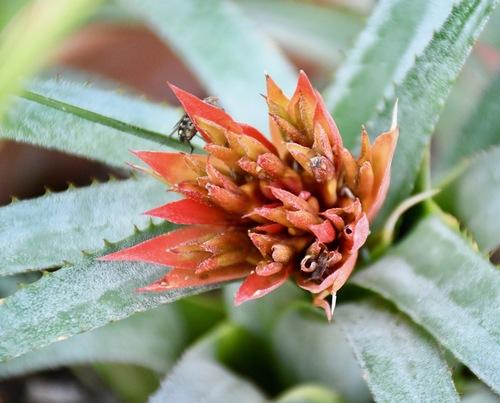

In [12]:
sample =  dataset['train'][1]
img = sample['image']
pixel_values = sample['pixel_values']
toks = sample['input_ids']
from torchvision.transforms import ToPILImage

to_pil = ToPILImage()
print(tokenizer.decode(toks))
to_pil(img.cpu().numpy())

In [281]:
model.eval()

with torch.no_grad():
    model.encoder.cuda()
    image_embedding = model.encoder(pixel_values.cuda().unsqueeze(0)).last_hidden_state
    image_embedding

In [15]:
seq = torch.empty((1, 0)).int().cuda()


#seq = torch.Tensor([tokenizer.pad_token_id]*4).int().cuda().unsqueeze(0)
#seq

prompt = 'This pictu '
seq = tokenizer([prompt])[:, :len(prompt)].cuda()
seq

tensor([[ 84, 104, 105, 115,  32, 112, 105,  99, 116, 117,  32]],
       device='cuda:0')

In [16]:
model.eval()

#seq = torch.Tensor([tokenizer.pad_token_id]*4).int().cuda().unsqueeze(0)
#seq = torch.Tensor([84, tokenizer.pad_token_id]).int().cuda().unsqueeze(0)

seq = torch.cat((seq, torch.Tensor([[tokenizer.pad_token_id]]).cuda()), dim=-1).int()
with torch.no_grad():
    print(seq)
    model.decoder.cuda()
    #result = model.decoder.model(seq, encoder_hidden_states=image_embedding)
    result = model.decoder.model(seq)
    print(result.shape)
    best_toks = torch.argmax(result, dim=-1)
    print(best_toks)
    seq[0, -1] = best_toks[-1, -1]
    #seq = torch.cat((seq, best_toks[:, -1].unsqueeze(0)), dim = -1).int()
    print("new seq: ", seq)
    print("txt: ", tokenizer.decode(seq)) 
    #seq = best_toks
    

tensor([[ 84, 104, 105, 115,  32, 112, 105,  99, 116, 117,  32, 257]],
       device='cuda:0', dtype=torch.int32)
torch.Size([1, 12, 258])
tensor([[ 84, 104, 105, 115,  32, 112, 105,  99, 116, 117,  32, 112]],
       device='cuda:0')
new seq:  tensor([[ 84, 104, 105, 115,  32, 112, 105,  99, 116, 117,  32, 112]],
       device='cuda:0', dtype=torch.int32)
txt:  ['This pictu p']


/usr/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


(64, 4)

In [18]:

from MEGABYTE_pytorch.megabyte import reduce_mult, gumbel_sample, top_k, exists
from einops import rearrange

model.cuda()
model.eval()

def generate(decoder, prime = None, filter_thres = 0.9, temperature = 1., default_batch_size = 1):
    total_seq_len = reduce_mult(decoder.model.max_seq_len)
    device = next(decoder.parameters()).device

    if not exists(prime):
        prime = torch.empty((default_batch_size, 0), dtype = torch.long, device = device)

    seq = prime
    batch = seq.shape[0]

    for _ in range(total_seq_len - seq.shape[-1]):
        out, loss = decoder.forward(seq)
        #print(out)
        logits = out[:, -1]
        logits = top_k(logits, thres = filter_thres)
        sampled = gumbel_sample(logits, dim = -1, temperature = temperature)
        seq = torch.cat((seq, rearrange(sampled, 'b -> b 1')), dim = -1)

    return seq.reshape(batch, *decoder.model.max_seq_len).flatten(-1)

prompt = "This picture di"
X = tokenizer.tokenize(prompt)[:-1].unsqueeze(0).cuda()
X

Y = generate(decoder, X)

/usr/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


In [33]:
X

tensor([[ 84, 104, 105, 115,  32, 112, 105,  99, 116, 117, 114, 101,  32, 100,
         105]], device='cuda:0')

In [25]:
Y.flatten()

tensor([ 84, 104, 105, 115,  32, 112, 105,  99, 116, 117, 114, 101,  32, 100,
        105,  60, 149,  52, 145,  84, 184,  30,  20,  30, 152, 243,  66, 114,
         34,  82, 145, 104,  84,  66, 104, 123, 242, 212,  98, 254,  60, 160,
        253,  11,  11,  66,  98, 116,  91, 156, 232, 237, 143,  27, 238, 160,
        238,  30,  29, 108, 160, 136, 257, 256, 191, 104, 156,  46,  98, 232,
         30,  77, 110,  42,  66, 195,  73, 156,   8, 253, 245, 169, 108,  60,
        175, 101, 257, 136,  33, 232,  36, 160, 142,  21,  22, 256, 114,  60,
        157,   8, 241, 104, 104, 104, 242,  29,   8,  11,  99,  11,  71,  71,
         26,  60, 204, 160, 196,  30, 257,  36, 151,  29,  79,   8,  56, 127,
        104, 254, 187, 127,  11,   8,  83,  18, 199, 257, 154,  11, 115,  42,
        222, 160,  21,  38,  18, 145, 104,   5, 105, 136, 108, 160,  55, 108,
         66, 169, 213, 108,  20, 129,  82, 204,  36,  36,  56, 199,   2, 156,
        240, 257,   8,   8, 243,   4, 108, 204,  34,  66, 113, 1

In [32]:
tokenizer.decode(Y.flatten()[:16])

['This picture di<']

In [17]:

beams = torch.Tensor([[tokenizer.pad_token_id]] * num_beams).cuda().int()

In [60]:
num_beams = 3


beams = torch.Tensor([[tokenizer.pad_token_id]] * num_beams).cuda().int()
probs = torch.zeros((num_beams,)).float().cuda()


MAX_LEN = 24

print(beams.shape, probs)
model.decoder.model.eval()
with torch.no_grad():
    for n in range(MAX_LEN):
        #print(beams.shape)
        model.decoder.cuda()
        #result = model.decoder.model(seq, encoder_hidden_states=image_embedding)
        #print("input shape:", beams.shape)
        result = model.decoder.model(beams)
        #print("result.shape", result.shape)
        # (B, T, V)
        best_toks = torch.topk(result[:, -1, :], num_beams, dim=-1)
        if beams.shape[-1] == 1:
            #initial run
            beams = best_toks.indices[0].reshape((-1, 1))
            probs = best_toks.values[0]
            #print("Initial run: ", beams.tolist(), probs.tolist(), beams.shape)
            beams = torch.cat((beams, torch.Tensor([[tokenizer.pad_token_id]] * num_beams).cuda()), dim=-1).int()
            continue
                

        all_new_probs = (probs.repeat((num_beams, 1)).transpose(1, 0).reshape(1, -1) * n + best_toks.values.reshape(1,-1)) / (n+1)
        #print(all_new_probs)
        selected = torch.topk(all_new_probs, num_beams)
        selected_beam_indices = selected.indices.squeeze() // num_beams
        selected_new_toks = selected.indices.squeeze() - selected_beam_indices

        selected_beams = beams[selected_beam_indices]
        #selected_beams[-1] = selected_new_toks
        selected_tok_indices = selected_beam_indices * num_beams + selected_new_toks
        selected_toks = best_toks.indices.reshape(-1)[selected_tok_indices]
        selected_probs = all_new_probs.reshape(-1)[selected_tok_indices]
        selected_toks, selected_probs
        selected_beams[:, -1] = selected_toks.squeeze()
        print("txt: ", tokenizer.decode(selected_beams)) 
        beams = torch.cat((selected_beams, torch.Tensor([[tokenizer.pad_token_id]]*num_beams).cuda()), dim=-1).int()
        probs = selected_probs
        beams

        

        #beams = torch.cat((beams, torch.Tensor([[tokenizer.pad_token_id]]).cuda()), dim=-1).int()
    #seq = best_toks

torch.Size([3, 1]) tensor([0., 0., 0.], device='cuda:0')
txt:  ['Th', 'Tp', 'Ts']
txt:  ['Thi', 'Thp', 'Thh']
txt:  ['This', 'Thip', 'Thih']
txt:  ['This ', 'ThisT', 'Thisp']


../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [0,0,0], thread: [1,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [34]:
best_toks.values

tensor([[9.8109, 2.6513],
        [7.4816, 4.8467]], device='cuda:0')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [21]:
all_new_probs

tensor([104, 112, 104, 112], device='cuda:0')

In [34]:
selected_beams

tensor([[[ 84, 257],
         [104, 112]]], device='cuda:0', dtype=torch.int32)

In [52]:
num_beams = 2
all_new_probs = (probs.repeat((num_beams, 1)).transpose(1, 0).reshape(1, -1) * n + best_toks.values.reshape(1,-1)) / (n+1)
print(all_new_probs)
selected = torch.topk(all_new_probs, num_beams)
selected_beam_indices = selected.indices.squeeze() // num_beams
selected_new_toks = selected.indices.squeeze() - selected_beam_indices

selected_beams = beams[selected_beam_indices]
#selected_beams[-1] = selected_new_toks
selected_tok_indices = selected_beam_indices * num_beams + selected_new_toks
selected_toks = best_toks.indices.reshape(-1)[selected_tok_indices]
selected_probs = all_new_probs.reshape(-1)[selected_tok_indices]
selected_toks, selected_probs
selected_beams[:, -1] = selected_toks.squeeze()
beams = torch.cat((selected_beams, torch.Tensor([[tokenizer.pad_token_id]]*num_beams).cuda()), dim=-1).int()
probs = selected_probs
beams


tensor([[8.2995, 5.2194, 5.9308, 4.0910]], device='cuda:0')


tensor([[ 84, 104, 104, 104, 104, 104, 104, 257],
        [ 84, 104, 104, 104, 104, 112, 112, 257]], device='cuda:0',
       dtype=torch.int32)

In [44]:
selected_beams[:, -1] = selected_toks.squeeze()

In [45]:
selected_beams, selected_toks, selected_beams[:, -1]

(tensor([[ 84, 104],
         [ 84, 112]], device='cuda:0', dtype=torch.int32),
 tensor([104, 112], device='cuda:0'),
 tensor([104, 112], device='cuda:0', dtype=torch.int32))

In [128]:
selected = torch.topk(best_toks.values.reshape(-1), 2, )
new_probs = selected.values
selected_beams =a selected.indices // num_beams
selected_new_toks = best_toks.indices.reshape(-1)[selected.indices]
selected_new_toks

tensor([84, 84], device='cuda:0')

In [ ]:
import math

def beam_search(start, transition_fn, score_fn, beam_width, max_len):
    # `start`: the initial state
    # `transition_fn`: a function that takes a state and returns a list of (action, next_state) pairs
    # `score_fn`: a function that takes an action and returns a score
    # `beam_width`: the number of candidates to keep at each step
    # `max_len`: the maximum length of the output sequence
    
    # Initialize the beam with the start state
    beam = [(start, [], 0)]
    
    # Iterate until we reach the maximum length or run out of candidates
    for i in range(max_len):
        candidates = []
        
        # Generate new candidates by expanding each current candidate
        for state, seq, score in beam:
            for action, next_state in transition_fn(state):
                new_seq = seq + [action]
                new_score = score + score_fn(action)
                candidates.append((next_state, new_seq, new_score))
                
        # Select the top `beam_width` candidates based on their scores
        beam = sorted(candidates, key=lambda x: x[2], reverse=True)[:beam_width]
        
    # Return the sequence with the highest score
    return max(beam, key=lambda x: x[2])[1]

In [90]:
output_ids = torch.argmax(result, dim=-1)
output_ids

tensor([[ 84, 104, 105, 115,  32, 112, 105,  99, 116, 117, 114, 101,  32,  99,
         111, 110, 116,  97, 105, 110, 115,  32,  97,  32,  97, 103,  97, 118,
         101,  95,  97, 109, 101, 114, 105,  99,  97, 110,  97,  32, 112, 108,
          97, 110, 116, 256,  97, 116,  97,  97,  97,  97,  97,  97,  97,  97,
          97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,
          97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,
          97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,
          97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,
          97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,  97,
          97,  97]], device='cuda:0')

In [92]:
toks

tensor([ 84, 104, 105, 115,  32, 112, 105,  99, 116, 117, 114, 101,  32,  99,
        111, 110, 116,  97, 105, 110, 115,  32,  97,  32,  97, 103,  97, 118,
        101,  95,  97, 109, 101, 114, 105,  99,  97, 110,  97,  32, 112, 108,
         97, 110, 116, 256, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257,
        257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257,
        257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257,
        257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257,
        257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257,
        257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257,
        257, 257])

In [94]:
tokenizer.eos_token_id

256

In [328]:
prompt = tokenizer(['This picture imag'])
#prompt = torch.Tensor([tokenizer.pad_token_id]*128).int().cuda().unsqueeze(0)

with torch.no_grad():
    result = model.decoder.model(prompt.cuda(), encoder_hidden_states=image_embedding)

tokenizer.decode(torch.argmax(result, dim=-1))

['This picture imaga a agghagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaag']

In [321]:
best_toks = 
best_toks

tensor([[ 84, 104, 105, 115,  32, 112, 105,  99,  84, 117, 114, 101,  32, 104,
         105,  97,  32, 104,  97, 100,  32, 117,  97, 100,  32, 117,  97, 100,
          32, 117,  97, 100,  32, 117,  97, 100,  32, 117,  97, 100,  32, 117,
          97, 100,  32, 117,  97, 100,  32, 117,  97, 100,  32, 117,  97, 100,
          32, 117,  97, 100,  32, 117,  97, 100,  32, 117,  97, 100,  32, 117,
          97, 100,  32, 117,  97, 100,  32, 117,  97, 100,  32, 117,  97, 100,
          32, 117,  97, 100,  32, 117,  97, 103,  32, 117,  97, 103,  32, 117,
          97, 103,  32, 117,  97, 103,  32, 117,  97, 103,  32, 117,  97, 103,
          32, 117,  97, 103,  32, 117,  97, 103,  32, 117,  97, 103,  32, 117,
          97, 103]], device='cuda:0')

tensor([[ 84, 104, 105, 115,  32, 112, 105,  99, 116, 117, 114, 101,  32, 105,
         109,  97, 103, 101, 115,  32,  97,  32,  97, 101,  99, 104, 109, 101,
          97, 256, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257,
         257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257,
         257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257,
         257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257,
         257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257,
         257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257,
         257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257,
         257, 257]])

In [109]:
from queue import PriorityQueue
import operator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class BeamSearchNode(object):
    def __init__(self, 
                 #hiddenstate, 
                 previousNode, wordId, logProb, length):
        '''
        :param hiddenstate:
        :param previousNode:
        :param wordId:
        :param logProb:
        :param length:
        '''
        #self.h = hiddenstate
        self.prevNode = previousNode
        self.wordid = wordId
        self.logp = logProb
        self.leng = length

    def eval(self, alpha=1.0):
        reward = 0
        # Add here a function for shaping a reward

        return self.logp / float(self.leng - 1 + 1e-6) + alpha * reward



    


def beam_decode(num_sentences, encoder_outputs=None):
    '''
    :param target_tensor: target indexes tensor of shape [B, T] where B is the batch size and T is the maximum length of the output sentence
    :param decoder_hidden: input tensor of shape [1, B, H] for start of the decoding
    :param encoder_outputs: if you are using attention mechanism you can pass encoder outputs, [T, B, H] where T is the maximum length of input sentence
    :return: decoded_batch
    '''

    beam_width = 10
    topk = 1  # how many sentence do you want to generate
    decoded_batch = []

    # decoding goes sentence by sentence
    for idx in range(num_sentences):
        #if isinstance(decoder_hiddens, tuple):  # LSTM case
        #    decoder_hidden = (decoder_hiddens[0][:,idx, :].unsqueeze(0),decoder_hiddens[1][:,idx, :].unsqueeze(0))
        #else:
        #    decoder_hidden = decoder_hiddens[:, idx, :].unsqueeze(0)
        #encoder_output = encoder_outputs[:,idx, :].unsqueeze(1)

        # Start with the start of the sentence token
        decoder_input = torch.Tensor([[decoder.config.pad_token_id]]).long().to(device)

        # Number of sentence to generate
        endnodes = []
        number_required = min((topk + 1), topk - len(endnodes))

        # starting node -  hidden vector, previous node, word id, logp, length
        node = BeamSearchNode(None, decoder_input, 0, 1)
        nodes = PriorityQueue()

        # start the queue
        nodes.put((-node.eval(), node))
        qsize = 1

        # start beam search
        while True:
            # give up when decoding takes too long
            if qsize > 20: break

            # fetch the best node
            score, n = nodes.get()
            decoder_input = n.wordid
            #decoder_hidden = n.h

            if n.wordid.item() == decoder.config.eos_token_id and n.prevNode != None:
                endnodes.append((score, n))
                # if we reached maximum # of sentences required
                if len(endnodes) >= number_required:
                    break
                else:
                    continue

            # decode for one step using decoder
            print(decoder_input)
            decoder_output = decoder.model(decoder_input, encoder_hidden_states=encoder_outputs)
            decoder_output = decoder_output[0]
            # PUT HERE REAL BEAM SEARCH OF TOP
            log_prob, indexes = torch.topk(decoder_output, beam_width)
            nextnodes = []

            for new_k in range(beam_width):
                decoded_t = indexes[0][new_k].view(1, -1)
                print(log_prob.shape)
                log_p = log_prob[0][new_k].item()

                node = BeamSearchNode(n, decoded_t, n.logp + log_p, n.leng + 1)
                score = -node.eval()
                nextnodes.append((score, node))

            # put them into queue
            for i in range(len(nextnodes)):
                score, nn = nextnodes[i]
                nodes.put((score, nn))
                # increase qsize
            qsize += len(nextnodes) - 1

        # choose nbest paths, back trace them
        if len(endnodes) == 0:
            endnodes = [nodes.get() for _ in range(topk)]

        utterances = []
        for score, n in sorted(endnodes, key=operator.itemgetter(0)):
            utterance = []
            utterance.append(n.wordid)
            # back trace
            while n.prevNode != None:
                n = n.prevNode
                utterance.append(n.wordid)

            utterance = utterance[::-1]
            utterances.append(utterance)

        decoded_batch.append(utterances)

    return decoded_batch

beam_decode(1)

tensor([[257]], device='cuda:0')
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
tensor([[84]], device='cuda:0')
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
tensor([[84]], device='cuda:0')
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])


[[[tensor([[257]], device='cuda:0'),
   tensor([[84]], device='cuda:0'),
   tensor([[84]], device='cuda:0'),
   tensor([[84]], device='cuda:0')]]]

In [ ]:
decoder.config.pad_token_id